In [1]:
import os
import torch
import numpy as np
from ezflow.data import DeviceDataLoader, DataloaderCreator

from nnflow import flow_to_image
from PIL import Image
import cv2 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ezflow.models import build_model
from ezflow.utils import AverageMeter, InputPadder
from nnflow import GMFlowV2, SCCFlow
from nnflow.models.gmflow import NAT
from nnflow import CustomDataloaderCreator

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [16]:
norm_params = {"use":False, "mean":[0.485, 0.456, 0.406], "std":[0.229, 0.224, 0.225]}

train_aug_params = {
        "eraser_aug_params":{"enabled": False, "aug_prob": 0.5, "bounds": [50, 100]},
        "noise_aug_params":{"enabled": False, "aug_prob": 0.5, "noise_std_range": 0.06},
        "flip_aug_params":{"enabled": True, "h_flip_prob": 0.5, "v_flip_prob": 0.1},
        "color_aug_params":{
            "enabled": False,
            "asymmetric_color_aug_prob": 0.2,
            "brightness": 0.4,
            "contrast": 0.4,
            "saturation": 0.4,
            "hue": 0.15915494309189535,
        },
        "spatial_aug_params":{
            "enabled": False,
            "aug_prob": 0.8,
            "stretch_prob": 0.8,
            "min_scale": -0.1,
            "max_scale": 1.0,
            "max_stretch": 0.2,
        },
        "advanced_spatial_aug_params":{
            "enabled": True,
            "scale1": 0.3,
            "scale2": 0.1,
            "rotate": 0.4,
            "translate": 0.4,
            "stretch": 0.3,
            "enable_out_of_boundary_crop": False,
        }
    }

In [17]:
loader = CustomDataloaderCreator(batch_size=100, num_workers=4, pin_memory=True, shuffle=False)
loader.add_Kubric(
    root_dir="../../KubricFlow",
    crop=True,
    crop_type="center",
    crop_size=[512, 512],
    split="training", 
    augment=True,
    aug_params=train_aug_params,
    norm_params=norm_params
)
_ds = loader.dataset_list[0]

In [233]:
dl = loader.get_dataloader()

Total image pairs loaded: 131900/131951



In [234]:
(img1,img2), flow=next(iter(dl))
flow.shape

torch.Size([100, 2, 512, 512])

In [242]:
zero_grid = torch.zeros_like(flow)
zero_grid.shape

torch.Size([100, 2, 512, 512])

In [243]:
disp = torch.norm(flow-zero_grid, p=2, dim=1)
disp.shape

torch.Size([100, 512, 512])

In [244]:
counts, bins = torch.histogram(disp, torch.tensor([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,200.]))

In [245]:
counts, bins

(tensor([1734235.,  698971.,  366772.,  119452.,   81445.,   44193.,       0.,
               0.,       0.,       0.]),
 tensor([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 200.]))

In [ ]:
x = [0 for i in range(10)]
y = [0 for i in range(10)]
count = 0
dl = loader.get_dataloader()
for (img1, img2), flow in dl:
    zero_grid = torch.zeros_like(flow)
    displacements = torch.norm(flow-zero_grid, p=2, dim=1)
    counts, bins = torch.histogram(displacements, torch.tensor([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,200.]))
    for k in range(len(counts)):
        x[k] = bins[k].detach().cpu().item()
        y[k] += counts[k].detach().cpu().item()
        
    count +=1
    if count%100 == 0:
        print(f"Processed {count*100}")

Total image pairs loaded: 131900/131951



/home/goswami.p/miniconda3/envs/ezflow/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/goswami.p/miniconda3/envs/ezflow/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/goswami.p/miniconda3/envs/ezflow/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/con

Processed 10000
Processed 20000
Processed 30000
Processed 40000
Processed 50000
Processed 60000
Processed 70000


In [ ]:
x,y

In [8]:
from copy import deepcopy

In [9]:
y_augmented_b_kubric = deepcopy(y)

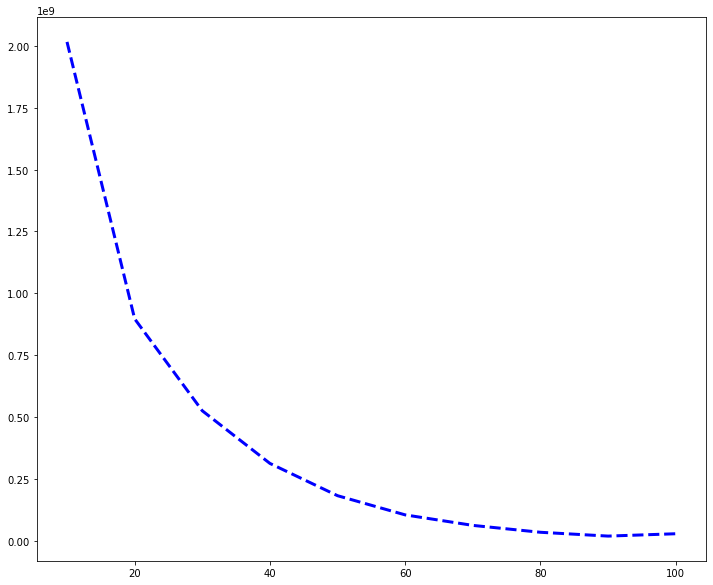

In [11]:
plt.figure(figsize=(12,10))

y_augmented_b_kubric = y_augmented_b_kubric

plt.plot(x, y_augmented_b_kubric, color = 'blue', linewidth=3, linestyle='dashed')
plt.show()

In [12]:
np.save("y_augmented_b_kubric.npy", np.asarray(y_augmented_b_kubric))

In [13]:
np_y_kubric = np.load("y_kubric.npy")
list(np_y_kubric)

[1689346338.0,
 709539554.0,
 356712993.0,
 162500868.0,
 69553532.0,
 29892576.0,
 13994935.0,
 7367309.0,
 4266724.0,
 8627092.0]

In [14]:
np_y_aug_a_kubric = np.load("y_augmented_a_kubric.npy")
list(np_y_aug_a_kubric)

[2016121976.0,
 896979545.0,
 525365621.0,
 312622278.0,
 182138083.0,
 104592804.0,
 62131955.0,
 34282359.0,
 18887833.0,
 28369728.0]

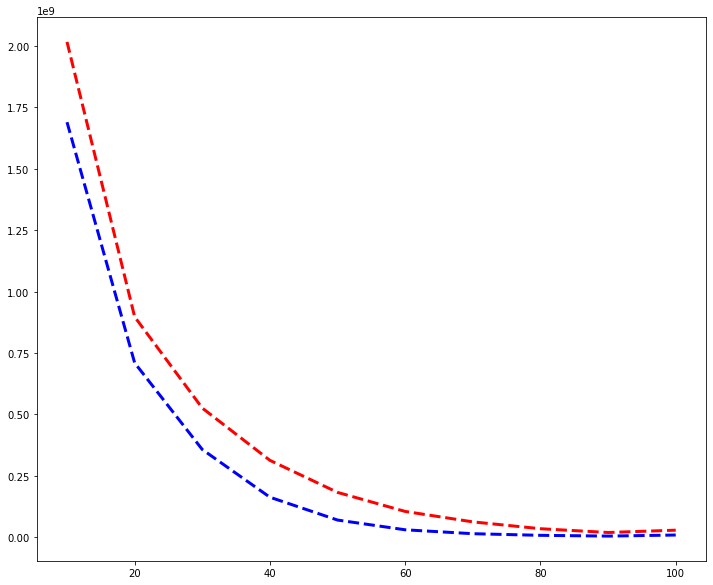

In [15]:
plt.figure(figsize=(12,10))


plt.plot(x, np_y_kubric, color = 'blue', linewidth=3, linestyle='dashed')
plt.plot(x, np_y_aug_a_kubric, color = 'red', linewidth=3, linestyle='dashed')

plt.show()

In [12]:
# (img1, img2), flow = sintel_ds[130]

In [13]:
# model = build_model(
#         "GMFlowV2", 
#         cfg_path="../configs/gmflow/models/gmflow_v13.yaml", 
#         custom_cfg=True
#     )

# model = build_model(
#         "FlowNetC", 
#         cfg_path="../configs/flownet_c/models/flownet_c.yaml", 
#         custom_cfg=True
#     )
# model.cfg.UPDATE_ITERS =32

In [14]:
# state_dict = torch.load("../../results/gmflow/ckpts/exp225/gmflowv2_best.pth", map_location=torch.device('cpu'))
# state_dict = torch.load("../../../ezflow_pretrained_ckpts/flownetc_kubric_step1200k.pth", map_location=torch.device('cpu'))

In [15]:
# model.load_state_dict(state_dict)
# model = model.to(device)

In [16]:
# path = "../../../ezflow_pretrained_ckpts"

# torch.save(
#     model.state_dict(),
#     os.path.join(path, "flownetc" + "_kubric_step1200000.pth")
# )

In [17]:
# img1 = img1.to(device)
# img2 = img2.to(device)

In [18]:
# padder = InputPadder(img1.shape, divisor=1)
# img1, img2 = padder.pad(img1, img2)

In [19]:
# model.eval()

# output = model(img1.unsqueeze(dim=0), img2.unsqueeze(dim=0))
# flow_pred = output["flow_upsampled"] #padder.unpad(output["flow_upsampled"]) * 20.0
# flow_pred.shape

In [9]:
# flow_pred = flow_pred.squeeze(dim=0).cpu().detach().permute(1,2,0).numpy()
# flow_pred.shape

In [8]:
# flow_pred_color = flow_to_image(flow_pred)
# plt.figure(figsize=(12,10))

# plt.imshow(flow_pred_color)

In [47]:
def point_vec(img,flow):
    meshgrid = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
    dispimg = cv2.resize(img, None,fx=4,fy=4)
    colorflow = flow_to_image(flow).astype(int)
    for i in range(img.shape[1]): # x 
        for j in range(img.shape[0]): # y
            # if flow[j,i,2] != 1: continue
            if j%10!=0 or i%10!=0: continue
            xend = int((meshgrid[0][j,i]+flow[j,i,0])*4)
            yend = int((meshgrid[1][j,i]+flow[j,i,1])*4)
            leng = np.linalg.norm(flow[j,i,:2])
            if leng<1:continue
            dispimg = cv2.arrowedLine(dispimg, (meshgrid[0][j,i]*4,meshgrid[1][j,i]*4),\
                                      (xend,yend),
                                      (int(colorflow[j,i,2]),int(colorflow[j,i,1]),int(colorflow[j,i,0])),2,tipLength=8/(leng+10),line_type=cv2.LINE_AA)
    return dispimg 

In [36]:
(img1, img2), flow = sintel_ds[60]

In [37]:
img1.shape

torch.Size([3, 384, 384])

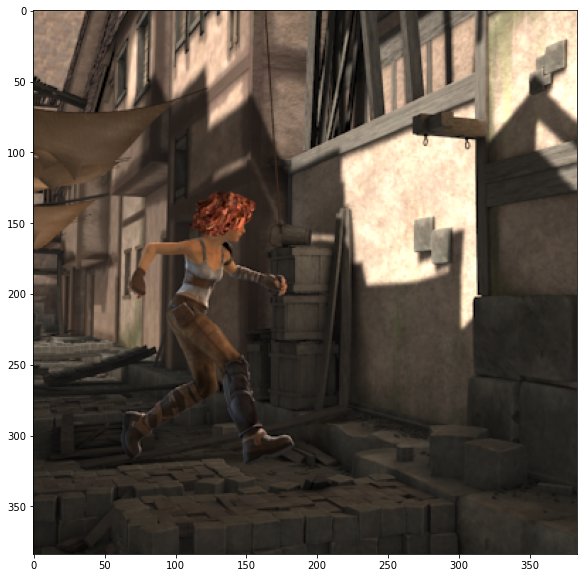

In [38]:
plt.figure(figsize=(12,10))

plt.imshow(img1.permute(1,2,0).numpy().astype(np.uint8))

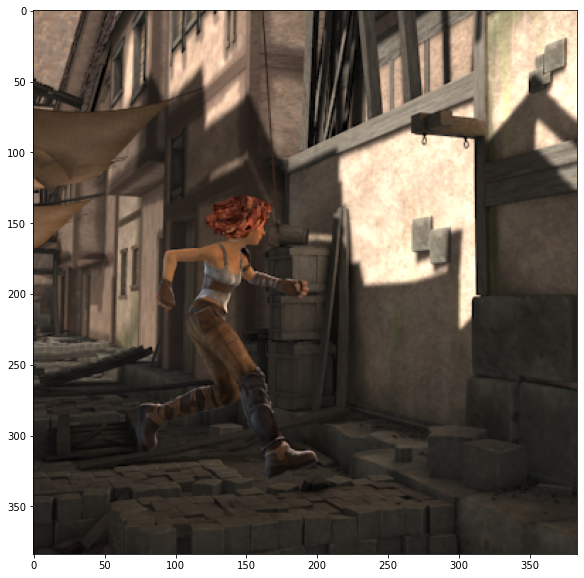

In [39]:
plt.figure(figsize=(12,10))

plt.imshow(img2.permute(1,2,0).numpy().astype(np.uint8))

In [40]:
flow_color = flow_to_image(flow.permute(1,2,0).numpy())

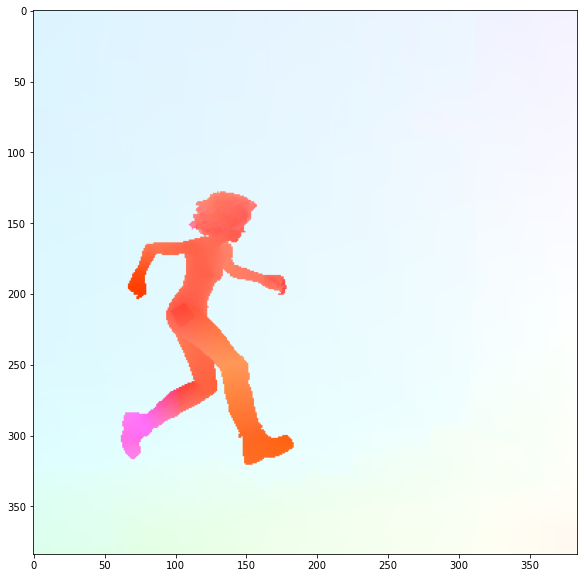

In [41]:
plt.figure(figsize=(12,10))

plt.imshow(flow_color)

In [48]:
flow_arrow = point_vec(img1.permute(1,2,0).numpy().astype(np.uint8), flow.permute(1,2,0).numpy())
flow_arrow.shape

(1536, 1536, 3)

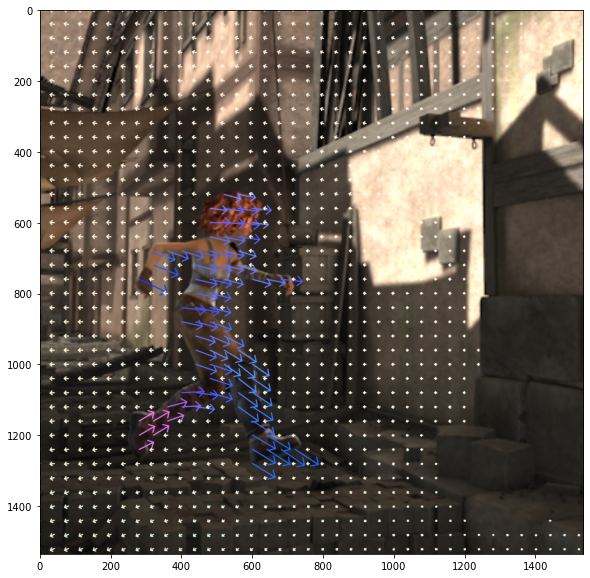

In [49]:
plt.figure(figsize=(12,10))

plt.imshow(flow_arrow)

In [50]:
_img1 = Image.fromarray(img1.permute(1,2,0).numpy().astype(np.uint8))
_img2 = Image.fromarray(img2.permute(1,2,0).numpy().astype(np.uint8))
_flow = Image.fromarray(flow_color)
_flow_arrow = Image.fromarray(flow_arrow)

_img1.size, _img2.size, _flow.size, _flow_arrow.size

((384, 384), (384, 384), (384, 384), (1536, 1536))

In [51]:
filepath = "../../viz/slides"

os.makedirs(filepath, exist_ok=True)

_img1.save(filepath+"/img1.jpg")
_img2.save(filepath+"/img2.jpg")
_flow.save(filepath+"/flow_color.jpg")
_flow_arrow.save(filepath+"/flow_arrow.jpg")